<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter09/predicting_multiple_instances_of_multiple_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
# !wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
# !tar -xf images.tar
# !tar -xf annotations_instance.tar
# !rm images.tar annotations_instance.tar
# !pip install -qU torch_snippets
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
# !pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 36.7MB 77kB/s 
     |████████████████████████████████| 102kB 14.6MB/s 


In [1]:
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

In [3]:
classes_list = [4,6]
annots = []
for ann in Tqdm(all_annots):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if np.array([num in np.unique(r) for num in classes_list]).sum()==0: continue
    annots.append(ann)
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 20210/20210 [01:56<00:00, 173.22it/s]


In [9]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [10]:
def get_mask(path):
    an = read(path, 1).transpose(2,0,1)
    r,g,b = an
    cls = list(set(np.unique(r)).intersection({4,6}))
    print(cls)
    masks = []
    labels = []
    for _cls in cls:
      nzs = np.nonzero(r==_cls)
      instances = np.unique(g[nzs])
      for ix,_id in enumerate(instances):
          masks.append(g==_id)
          labels.append(classes_list.index(_cls)+1)
    return np.array(masks), np.array(labels)

In [11]:
_id = trn_items[10]
img_path = f'images/training/{_id}.jpg'

In [12]:
get_mask(img_path)

[4, 6]


(array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, 

Tensor	Shape: torch.Size([3, 300, 400])	Min: 0.000	Max: 1.000	Mean: 0.390	dtype: torch.float32
Dict Of 6 items
	BOXES:
	Tensor	Shape: torch.Size([4, 4])	Min: 0.000	Max: 391.000	Mean: 196.875	dtype: torch.float32
	LABELS:
	Tensor	Shape: torch.Size([4])	Min: 2.000	Max: 2.000	Mean: 2.000	dtype: torch.int64
	MASKS:
	Tensor	Shape: torch.Size([4, 300, 400])	Min: 0.000	Max: 1.000	Mean: 0.031	dtype: torch.uint8
	IMAGE_ID:
	Tensor	Shape: torch.Size([1])	Min: 1.000	Max: 1.000	Mean: 1.000	dtype: torch.int64
	AREA:
	Tensor	Shape: torch.Size([4])	Min: 1683.000	Max: 13068.000	Mean: 5882.000	dtype: torch.float32
... ... -4 more item(s)


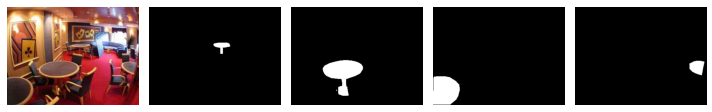

In [14]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    def get_mask(self,path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        cls = list(set(np.unique(r)).intersection({4,6}))
        masks = []
        labels = []
        for _cls in cls:
          nzs = np.nonzero(r==_cls)
          instances = np.unique(g[nzs])
          for ix,_id in enumerate(instances):
              masks.append(g==_id)
              labels.append(classes_list.index(_cls)+1)
        return np.array(masks), np.array(labels)
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks, labels = self.get_mask(mask_path)
        #print(labels)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            img = (img/255.0).type(torch.FloatTensor)
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[1]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

In [15]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [16]:
model = get_model_instance_segmentation(3).to(device)

In [17]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=3000)
dataset_test = MasksDataset(val_items, get_transform(train=False), N=800)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [18]:
num_classes = 3
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [19]:
model.eval()
pred = model(dataset[0][0][None].to(device))
inspect(pred[0])

Dict Of 4 items
	BOXES:
	Tensor	Shape: torch.Size([100, 4])	Min: 0.000	Max: 660.574	Mean: 323.892	dtype: torch.float32
	LABELS:
	Tensor	Shape: torch.Size([100])	Min: 1.000	Max: 1.000	Mean: 1.000	dtype: torch.int64
	SCORES:
	Tensor	Shape: torch.Size([100])	Min: 0.419	Max: 0.639	Mean: 0.476	dtype: torch.float32
	MASKS:
	Tensor	Shape: torch.Size([100, 1, 512, 683])	Min: 0.000	Max: 0.915	Mean: 0.000	dtype: torch.float32


/home/guy/anaconda3/envs/ptvit/lib/python3.8/site-packages/torch-1.10.1-py3.8-linux-x86_64.egg/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [20]:
num_epochs = 5

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1500]  eta: 0:17:35  lr: 0.000010  loss: 3.9026 (3.9026)  loss_classifier: 1.0134 (1.0134)  loss_box_reg: 0.2483 (0.2483)  loss_mask: 2.6055 (2.6055)  loss_objectness: 0.0323 (0.0323)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 0.7036  data: 0.0450  max mem: 4088
Epoch: [0]  [  10/1500]  eta: 0:13:31  lr: 0.000060  loss: 3.5101 (3.7648)  loss_classifier: 0.9628 (0.9390)  loss_box_reg: 0.2544 (0.2637)  loss_mask: 2.3548 (2.5178)  loss_objectness: 0.0343 (0.0359)  loss_rpn_box_reg: 0.0071 (0.0084)  time: 0.5446  data: 0.0278  max mem: 4088
Epoch: [0]  [  20/1500]  eta: 0:13:04  lr: 0.000110  loss: 2.7956 (2.9997)  loss_classifier: 0.7926 (0.7728)  loss_box_reg: 0.2227 (0.2575)  loss_mask: 1.7595 (1.9107)  loss_objectness: 0.0312 (0.0405)  loss_rpn_box_reg: 0.0109 (0.0181)  time: 0.5214  data: 0.0238  max mem: 4088
Epoch: [0]  [  30/1500]  eta: 0:13:15  lr: 0.000160  loss: 1.5787 (2.4477)  loss_classifier: 0.4488 (0.6287)  loss_box_reg: 0.2126 (0.2560)  loss_mask: 0.8108 (

Epoch: [0]  [ 300/1500]  eta: 0:11:11  lr: 0.001508  loss: 0.5205 (1.0047)  loss_classifier: 0.0967 (0.2091)  loss_box_reg: 0.1338 (0.2235)  loss_mask: 0.3131 (0.5080)  loss_objectness: 0.0248 (0.0438)  loss_rpn_box_reg: 0.0059 (0.0202)  time: 0.5826  data: 0.0245  max mem: 4695
Epoch: [0]  [ 310/1500]  eta: 0:11:07  lr: 0.001558  loss: 0.5863 (0.9935)  loss_classifier: 0.0966 (0.2057)  loss_box_reg: 0.1199 (0.2212)  loss_mask: 0.3131 (0.5032)  loss_objectness: 0.0218 (0.0433)  loss_rpn_box_reg: 0.0059 (0.0201)  time: 0.5874  data: 0.0239  max mem: 4695
Epoch: [0]  [ 320/1500]  eta: 0:11:01  lr: 0.001608  loss: 0.6770 (0.9859)  loss_classifier: 0.1149 (0.2037)  loss_box_reg: 0.1767 (0.2208)  loss_mask: 0.2924 (0.4981)  loss_objectness: 0.0231 (0.0429)  loss_rpn_box_reg: 0.0085 (0.0203)  time: 0.5802  data: 0.0239  max mem: 4695
Epoch: [0]  [ 330/1500]  eta: 0:10:55  lr: 0.001658  loss: 0.6770 (0.9774)  loss_classifier: 0.0983 (0.2011)  loss_box_reg: 0.1441 (0.2188)  loss_mask: 0.3483 (

Epoch: [0]  [ 600/1500]  eta: 0:08:30  lr: 0.003007  loss: 0.6325 (0.8659)  loss_classifier: 0.1068 (0.1651)  loss_box_reg: 0.1305 (0.1951)  loss_mask: 0.3324 (0.4438)  loss_objectness: 0.0304 (0.0407)  loss_rpn_box_reg: 0.0135 (0.0212)  time: 0.5750  data: 0.0253  max mem: 4788
Epoch: [0]  [ 610/1500]  eta: 0:08:25  lr: 0.003057  loss: 0.5943 (0.8613)  loss_classifier: 0.0829 (0.1639)  loss_box_reg: 0.1131 (0.1939)  loss_mask: 0.3190 (0.4421)  loss_objectness: 0.0241 (0.0404)  loss_rpn_box_reg: 0.0056 (0.0211)  time: 0.5757  data: 0.0235  max mem: 4788
Epoch: [0]  [ 620/1500]  eta: 0:08:19  lr: 0.003107  loss: 0.7520 (0.8631)  loss_classifier: 0.1125 (0.1635)  loss_box_reg: 0.1105 (0.1935)  loss_mask: 0.3360 (0.4428)  loss_objectness: 0.0230 (0.0420)  loss_rpn_box_reg: 0.0066 (0.0213)  time: 0.5784  data: 0.0238  max mem: 4788
Epoch: [0]  [ 630/1500]  eta: 0:08:13  lr: 0.003157  loss: 0.7767 (0.8630)  loss_classifier: 0.1215 (0.1631)  loss_box_reg: 0.0972 (0.1927)  loss_mask: 0.4296 (

Epoch: [0]  [ 900/1500]  eta: 0:05:43  lr: 0.004505  loss: 0.7596 (0.8219)  loss_classifier: 0.0996 (0.1505)  loss_box_reg: 0.1431 (0.1823)  loss_mask: 0.4041 (0.4255)  loss_objectness: 0.0145 (0.0424)  loss_rpn_box_reg: 0.0101 (0.0211)  time: 0.5806  data: 0.0225  max mem: 5036
Epoch: [0]  [ 910/1500]  eta: 0:05:37  lr: 0.004555  loss: 0.7754 (0.8223)  loss_classifier: 0.0983 (0.1506)  loss_box_reg: 0.1429 (0.1826)  loss_mask: 0.3558 (0.4250)  loss_objectness: 0.0275 (0.0427)  loss_rpn_box_reg: 0.0114 (0.0215)  time: 0.5854  data: 0.0270  max mem: 5036
Epoch: [0]  [ 920/1500]  eta: 0:05:31  lr: 0.004605  loss: 0.5909 (0.8201)  loss_classifier: 0.0964 (0.1501)  loss_box_reg: 0.1182 (0.1819)  loss_mask: 0.3340 (0.4240)  loss_objectness: 0.0328 (0.0426)  loss_rpn_box_reg: 0.0114 (0.0215)  time: 0.5794  data: 0.0265  max mem: 5036
Epoch: [0]  [ 930/1500]  eta: 0:05:25  lr: 0.004655  loss: 0.5504 (0.8173)  loss_classifier: 0.0779 (0.1494)  loss_box_reg: 0.0957 (0.1809)  loss_mask: 0.3335 (

Epoch: [0]  [1200/1500]  eta: 0:02:51  lr: 0.005000  loss: 0.6569 (0.7990)  loss_classifier: 0.0763 (0.1426)  loss_box_reg: 0.0847 (0.1754)  loss_mask: 0.3829 (0.4140)  loss_objectness: 0.0374 (0.0445)  loss_rpn_box_reg: 0.0167 (0.0225)  time: 0.5634  data: 0.0225  max mem: 5121
Epoch: [0]  [1210/1500]  eta: 0:02:46  lr: 0.005000  loss: 0.6009 (0.7978)  loss_classifier: 0.0795 (0.1420)  loss_box_reg: 0.0911 (0.1747)  loss_mask: 0.3825 (0.4141)  loss_objectness: 0.0367 (0.0445)  loss_rpn_box_reg: 0.0104 (0.0225)  time: 0.5569  data: 0.0215  max mem: 5121
Epoch: [0]  [1220/1500]  eta: 0:02:40  lr: 0.005000  loss: 0.6681 (0.7975)  loss_classifier: 0.0857 (0.1419)  loss_box_reg: 0.0941 (0.1746)  loss_mask: 0.3868 (0.4137)  loss_objectness: 0.0344 (0.0447)  loss_rpn_box_reg: 0.0168 (0.0226)  time: 0.5651  data: 0.0207  max mem: 5121
Epoch: [0]  [1230/1500]  eta: 0:02:34  lr: 0.005000  loss: 0.6216 (0.7961)  loss_classifier: 0.0926 (0.1415)  loss_box_reg: 0.0976 (0.1741)  loss_mask: 0.3513 (

Epoch: [0]  [1499/1500]  eta: 0:00:00  lr: 0.005000  loss: 0.5832 (0.7772)  loss_classifier: 0.0859 (0.1362)  loss_box_reg: 0.0988 (0.1677)  loss_mask: 0.3523 (0.4069)  loss_objectness: 0.0201 (0.0440)  loss_rpn_box_reg: 0.0054 (0.0223)  time: 0.5779  data: 0.0266  max mem: 5121
Epoch: [0] Total time: 0:14:20 (0.5739 s / it)
creating index...
index created!
Test:  [  0/800]  eta: 0:01:49  model_time: 0.1203 (0.1203)  evaluator_time: 0.0085 (0.0085)  time: 0.1368  data: 0.0075  max mem: 5121
Test:  [100/800]  eta: 0:01:44  model_time: 0.1113 (0.1177)  evaluator_time: 0.0108 (0.0187)  time: 0.1489  data: 0.0119  max mem: 5121
Test:  [200/800]  eta: 0:01:27  model_time: 0.1106 (0.1153)  evaluator_time: 0.0117 (0.0173)  time: 0.1421  data: 0.0120  max mem: 5121
Test:  [300/800]  eta: 0:01:13  model_time: 0.1199 (0.1166)  evaluator_time: 0.0061 (0.0168)  time: 0.1496  data: 0.0115  max mem: 5121
Test:  [400/800]  eta: 0:00:58  model_time: 0.1133 (0.1168)  evaluator_time: 0.0101 (0.0169)  ti

Epoch: [1]  [ 160/1500]  eta: 0:12:54  lr: 0.005000  loss: 0.6431 (0.6723)  loss_classifier: 0.1100 (0.1195)  loss_box_reg: 0.1116 (0.1640)  loss_mask: 0.3270 (0.3472)  loss_objectness: 0.0189 (0.0239)  loss_rpn_box_reg: 0.0086 (0.0177)  time: 0.6254  data: 0.0243  max mem: 5121
Epoch: [1]  [ 170/1500]  eta: 0:12:46  lr: 0.005000  loss: 0.6566 (0.6719)  loss_classifier: 0.0894 (0.1180)  loss_box_reg: 0.1242 (0.1622)  loss_mask: 0.3238 (0.3489)  loss_objectness: 0.0156 (0.0248)  loss_rpn_box_reg: 0.0069 (0.0181)  time: 0.5899  data: 0.0253  max mem: 5121
Epoch: [1]  [ 180/1500]  eta: 0:12:40  lr: 0.005000  loss: 0.6611 (0.6761)  loss_classifier: 0.0937 (0.1185)  loss_box_reg: 0.0963 (0.1633)  loss_mask: 0.3344 (0.3497)  loss_objectness: 0.0182 (0.0256)  loss_rpn_box_reg: 0.0080 (0.0189)  time: 0.5622  data: 0.0266  max mem: 5121
Epoch: [1]  [ 190/1500]  eta: 0:12:35  lr: 0.005000  loss: 0.6921 (0.6764)  loss_classifier: 0.0937 (0.1176)  loss_box_reg: 0.0960 (0.1637)  loss_mask: 0.3609 (

Epoch: [1]  [ 460/1500]  eta: 0:09:58  lr: 0.005000  loss: 0.6805 (0.6728)  loss_classifier: 0.1288 (0.1172)  loss_box_reg: 0.1556 (0.1560)  loss_mask: 0.3449 (0.3519)  loss_objectness: 0.0236 (0.0276)  loss_rpn_box_reg: 0.0142 (0.0200)  time: 0.5938  data: 0.0315  max mem: 5121
Epoch: [1]  [ 470/1500]  eta: 0:09:53  lr: 0.005000  loss: 0.6713 (0.6711)  loss_classifier: 0.1032 (0.1170)  loss_box_reg: 0.1129 (0.1553)  loss_mask: 0.3099 (0.3511)  loss_objectness: 0.0168 (0.0277)  loss_rpn_box_reg: 0.0122 (0.0200)  time: 0.5671  data: 0.0224  max mem: 5121
Epoch: [1]  [ 480/1500]  eta: 0:09:47  lr: 0.005000  loss: 0.5665 (0.6723)  loss_classifier: 0.0960 (0.1172)  loss_box_reg: 0.0969 (0.1560)  loss_mask: 0.3151 (0.3512)  loss_objectness: 0.0221 (0.0278)  loss_rpn_box_reg: 0.0133 (0.0201)  time: 0.5711  data: 0.0206  max mem: 5121
Epoch: [1]  [ 490/1500]  eta: 0:09:41  lr: 0.005000  loss: 0.5420 (0.6699)  loss_classifier: 0.0792 (0.1164)  loss_box_reg: 0.0852 (0.1545)  loss_mask: 0.3259 (

Epoch: [1]  [ 760/1500]  eta: 0:07:07  lr: 0.005000  loss: 0.5903 (0.6618)  loss_classifier: 0.0847 (0.1146)  loss_box_reg: 0.0890 (0.1495)  loss_mask: 0.3392 (0.3500)  loss_objectness: 0.0240 (0.0276)  loss_rpn_box_reg: 0.0065 (0.0203)  time: 0.5805  data: 0.0284  max mem: 5121
Epoch: [1]  [ 770/1500]  eta: 0:07:01  lr: 0.005000  loss: 0.5877 (0.6620)  loss_classifier: 0.0847 (0.1147)  loss_box_reg: 0.0998 (0.1498)  loss_mask: 0.3332 (0.3499)  loss_objectness: 0.0201 (0.0275)  loss_rpn_box_reg: 0.0073 (0.0203)  time: 0.5997  data: 0.0305  max mem: 5121
Epoch: [1]  [ 780/1500]  eta: 0:06:56  lr: 0.005000  loss: 0.6854 (0.6636)  loss_classifier: 0.1025 (0.1151)  loss_box_reg: 0.1546 (0.1504)  loss_mask: 0.3332 (0.3504)  loss_objectness: 0.0207 (0.0275)  loss_rpn_box_reg: 0.0092 (0.0203)  time: 0.5980  data: 0.0259  max mem: 5121
Epoch: [1]  [ 790/1500]  eta: 0:06:50  lr: 0.005000  loss: 0.7038 (0.6635)  loss_classifier: 0.0875 (0.1148)  loss_box_reg: 0.1447 (0.1504)  loss_mask: 0.3509 (

Epoch: [1]  [1060/1500]  eta: 0:04:13  lr: 0.005000  loss: 0.5961 (0.6702)  loss_classifier: 0.0727 (0.1139)  loss_box_reg: 0.0987 (0.1494)  loss_mask: 0.3507 (0.3551)  loss_objectness: 0.0245 (0.0305)  loss_rpn_box_reg: 0.0095 (0.0214)  time: 0.5904  data: 0.0238  max mem: 5121
Epoch: [1]  [1070/1500]  eta: 0:04:07  lr: 0.005000  loss: 0.5961 (0.6696)  loss_classifier: 0.0948 (0.1137)  loss_box_reg: 0.1082 (0.1491)  loss_mask: 0.3517 (0.3549)  loss_objectness: 0.0284 (0.0305)  loss_rpn_box_reg: 0.0082 (0.0213)  time: 0.5654  data: 0.0258  max mem: 5121
Epoch: [1]  [1080/1500]  eta: 0:04:01  lr: 0.005000  loss: 0.5635 (0.6690)  loss_classifier: 0.0691 (0.1135)  loss_box_reg: 0.0926 (0.1488)  loss_mask: 0.3517 (0.3549)  loss_objectness: 0.0245 (0.0305)  loss_rpn_box_reg: 0.0056 (0.0213)  time: 0.5615  data: 0.0241  max mem: 5121
Epoch: [1]  [1090/1500]  eta: 0:03:56  lr: 0.005000  loss: 0.6337 (0.6693)  loss_classifier: 0.0966 (0.1136)  loss_box_reg: 0.1163 (0.1488)  loss_mask: 0.3726 (

Epoch: [1]  [1360/1500]  eta: 0:01:20  lr: 0.005000  loss: 0.6047 (0.6689)  loss_classifier: 0.0687 (0.1132)  loss_box_reg: 0.0791 (0.1480)  loss_mask: 0.3811 (0.3560)  loss_objectness: 0.0132 (0.0303)  loss_rpn_box_reg: 0.0044 (0.0214)  time: 0.5640  data: 0.0221  max mem: 5121
Epoch: [1]  [1370/1500]  eta: 0:01:14  lr: 0.005000  loss: 0.6010 (0.6687)  loss_classifier: 0.0672 (0.1132)  loss_box_reg: 0.0822 (0.1481)  loss_mask: 0.3811 (0.3559)  loss_objectness: 0.0132 (0.0301)  loss_rpn_box_reg: 0.0077 (0.0214)  time: 0.5713  data: 0.0234  max mem: 5121
Epoch: [1]  [1380/1500]  eta: 0:01:09  lr: 0.005000  loss: 0.5281 (0.6678)  loss_classifier: 0.0709 (0.1129)  loss_box_reg: 0.0875 (0.1477)  loss_mask: 0.3377 (0.3558)  loss_objectness: 0.0105 (0.0300)  loss_rpn_box_reg: 0.0077 (0.0213)  time: 0.5807  data: 0.0233  max mem: 5121
Epoch: [1]  [1390/1500]  eta: 0:01:03  lr: 0.005000  loss: 0.5577 (0.6680)  loss_classifier: 0.0703 (0.1129)  loss_box_reg: 0.0912 (0.1476)  loss_mask: 0.3632 (

Epoch: [2]  [  20/1500]  eta: 0:13:53  lr: 0.005000  loss: 0.5616 (0.6296)  loss_classifier: 0.0954 (0.1099)  loss_box_reg: 0.0969 (0.1372)  loss_mask: 0.3354 (0.3376)  loss_objectness: 0.0133 (0.0321)  loss_rpn_box_reg: 0.0046 (0.0128)  time: 0.5667  data: 0.0250  max mem: 5121
Epoch: [2]  [  30/1500]  eta: 0:13:51  lr: 0.005000  loss: 0.5898 (0.6499)  loss_classifier: 0.0904 (0.1095)  loss_box_reg: 0.0972 (0.1433)  loss_mask: 0.3600 (0.3504)  loss_objectness: 0.0133 (0.0299)  loss_rpn_box_reg: 0.0071 (0.0167)  time: 0.5713  data: 0.0261  max mem: 5121
Epoch: [2]  [  40/1500]  eta: 0:14:05  lr: 0.005000  loss: 0.6164 (0.6553)  loss_classifier: 0.1097 (0.1137)  loss_box_reg: 0.1315 (0.1572)  loss_mask: 0.3426 (0.3380)  loss_objectness: 0.0161 (0.0285)  loss_rpn_box_reg: 0.0126 (0.0179)  time: 0.5957  data: 0.0257  max mem: 5121
Epoch: [2]  [  50/1500]  eta: 0:14:12  lr: 0.005000  loss: 0.6164 (0.6377)  loss_classifier: 0.1097 (0.1102)  loss_box_reg: 0.1315 (0.1519)  loss_mask: 0.2894 (

Epoch: [2]  [ 320/1500]  eta: 0:11:32  lr: 0.005000  loss: 0.6300 (0.6379)  loss_classifier: 0.0876 (0.1070)  loss_box_reg: 0.0864 (0.1519)  loss_mask: 0.3352 (0.3360)  loss_objectness: 0.0163 (0.0248)  loss_rpn_box_reg: 0.0040 (0.0181)  time: 0.6031  data: 0.0248  max mem: 5121
Epoch: [2]  [ 330/1500]  eta: 0:11:25  lr: 0.005000  loss: 0.6300 (0.6380)  loss_classifier: 0.0783 (0.1069)  loss_box_reg: 0.0958 (0.1517)  loss_mask: 0.3288 (0.3368)  loss_objectness: 0.0109 (0.0246)  loss_rpn_box_reg: 0.0087 (0.0180)  time: 0.6148  data: 0.0254  max mem: 5121
Epoch: [2]  [ 340/1500]  eta: 0:11:21  lr: 0.005000  loss: 0.6171 (0.6412)  loss_classifier: 0.0882 (0.1074)  loss_box_reg: 0.1196 (0.1534)  loss_mask: 0.3458 (0.3378)  loss_objectness: 0.0165 (0.0246)  loss_rpn_box_reg: 0.0132 (0.0181)  time: 0.6007  data: 0.0275  max mem: 5121
Epoch: [2]  [ 350/1500]  eta: 0:11:15  lr: 0.005000  loss: 0.5817 (0.6412)  loss_classifier: 0.0882 (0.1078)  loss_box_reg: 0.1582 (0.1531)  loss_mask: 0.3486 (

Epoch: [2]  [ 620/1500]  eta: 0:08:32  lr: 0.005000  loss: 0.7303 (0.6456)  loss_classifier: 0.1180 (0.1097)  loss_box_reg: 0.1234 (0.1509)  loss_mask: 0.3288 (0.3422)  loss_objectness: 0.0155 (0.0240)  loss_rpn_box_reg: 0.0083 (0.0188)  time: 0.6026  data: 0.0228  max mem: 5121
Epoch: [2]  [ 630/1500]  eta: 0:08:26  lr: 0.005000  loss: 0.5688 (0.6449)  loss_classifier: 0.0845 (0.1094)  loss_box_reg: 0.0881 (0.1507)  loss_mask: 0.3335 (0.3423)  loss_objectness: 0.0095 (0.0238)  loss_rpn_box_reg: 0.0052 (0.0187)  time: 0.5815  data: 0.0234  max mem: 5121
Epoch: [2]  [ 640/1500]  eta: 0:08:21  lr: 0.005000  loss: 0.5688 (0.6458)  loss_classifier: 0.0845 (0.1094)  loss_box_reg: 0.1004 (0.1509)  loss_mask: 0.3337 (0.3424)  loss_objectness: 0.0090 (0.0243)  loss_rpn_box_reg: 0.0052 (0.0188)  time: 0.5861  data: 0.0237  max mem: 5121
Epoch: [2]  [ 650/1500]  eta: 0:08:15  lr: 0.005000  loss: 0.6336 (0.6466)  loss_classifier: 0.0938 (0.1099)  loss_box_reg: 0.1004 (0.1511)  loss_mask: 0.3507 (

Epoch: [2]  [ 920/1500]  eta: 0:05:36  lr: 0.005000  loss: 0.5599 (0.6379)  loss_classifier: 0.0903 (0.1085)  loss_box_reg: 0.0786 (0.1479)  loss_mask: 0.3328 (0.3373)  loss_objectness: 0.0143 (0.0250)  loss_rpn_box_reg: 0.0142 (0.0192)  time: 0.5640  data: 0.0232  max mem: 5121
Epoch: [2]  [ 930/1500]  eta: 0:05:30  lr: 0.005000  loss: 0.5597 (0.6381)  loss_classifier: 0.0769 (0.1085)  loss_box_reg: 0.0891 (0.1477)  loss_mask: 0.3582 (0.3376)  loss_objectness: 0.0201 (0.0250)  loss_rpn_box_reg: 0.0114 (0.0192)  time: 0.5348  data: 0.0196  max mem: 5121
Epoch: [2]  [ 940/1500]  eta: 0:05:25  lr: 0.005000  loss: 0.6390 (0.6385)  loss_classifier: 0.0863 (0.1084)  loss_box_reg: 0.1200 (0.1476)  loss_mask: 0.3233 (0.3380)  loss_objectness: 0.0221 (0.0252)  loss_rpn_box_reg: 0.0090 (0.0193)  time: 0.5751  data: 0.0214  max mem: 5121
Epoch: [2]  [ 950/1500]  eta: 0:05:19  lr: 0.005000  loss: 0.6117 (0.6384)  loss_classifier: 0.0641 (0.1082)  loss_box_reg: 0.0980 (0.1472)  loss_mask: 0.3498 (

Epoch: [2]  [1220/1500]  eta: 0:02:42  lr: 0.005000  loss: 0.6618 (0.6361)  loss_classifier: 0.0840 (0.1086)  loss_box_reg: 0.1453 (0.1464)  loss_mask: 0.3249 (0.3367)  loss_objectness: 0.0139 (0.0253)  loss_rpn_box_reg: 0.0098 (0.0190)  time: 0.5822  data: 0.0237  max mem: 5121
Epoch: [2]  [1230/1500]  eta: 0:02:36  lr: 0.005000  loss: 0.6112 (0.6362)  loss_classifier: 0.0794 (0.1085)  loss_box_reg: 0.0936 (0.1464)  loss_mask: 0.3019 (0.3370)  loss_objectness: 0.0124 (0.0252)  loss_rpn_box_reg: 0.0098 (0.0191)  time: 0.5871  data: 0.0271  max mem: 5121
Epoch: [2]  [1240/1500]  eta: 0:02:30  lr: 0.005000  loss: 0.6152 (0.6359)  loss_classifier: 0.0629 (0.1083)  loss_box_reg: 0.0655 (0.1460)  loss_mask: 0.3246 (0.3370)  loss_objectness: 0.0121 (0.0254)  loss_rpn_box_reg: 0.0090 (0.0191)  time: 0.5965  data: 0.0273  max mem: 5121
Epoch: [2]  [1250/1500]  eta: 0:02:25  lr: 0.005000  loss: 0.5956 (0.6358)  loss_classifier: 0.0824 (0.1082)  loss_box_reg: 0.0862 (0.1459)  loss_mask: 0.3246 (

Test:  [100/800]  eta: 0:01:54  model_time: 0.1143 (0.1262)  evaluator_time: 0.0186 (0.0238)  time: 0.1569  data: 0.0120  max mem: 5219
Test:  [200/800]  eta: 0:01:35  model_time: 0.1156 (0.1236)  evaluator_time: 0.0142 (0.0227)  time: 0.1567  data: 0.0121  max mem: 5219
Test:  [300/800]  eta: 0:01:19  model_time: 0.1229 (0.1236)  evaluator_time: 0.0097 (0.0218)  time: 0.1563  data: 0.0115  max mem: 5219
Test:  [400/800]  eta: 0:01:03  model_time: 0.1242 (0.1246)  evaluator_time: 0.0164 (0.0223)  time: 0.1570  data: 0.0100  max mem: 5219
Test:  [500/800]  eta: 0:00:48  model_time: 0.1140 (0.1255)  evaluator_time: 0.0133 (0.0227)  time: 0.1642  data: 0.0123  max mem: 5219
Test:  [600/800]  eta: 0:00:32  model_time: 0.1225 (0.1264)  evaluator_time: 0.0182 (0.0234)  time: 0.1584  data: 0.0114  max mem: 5219
Test:  [700/800]  eta: 0:00:16  model_time: 0.1380 (0.1268)  evaluator_time: 0.0251 (0.0240)  time: 0.1761  data: 0.0121  max mem: 5219
Test:  [799/800]  eta: 0:00:00  model_time: 0.12

Epoch: [3]  [ 180/1500]  eta: 0:12:39  lr: 0.000500  loss: 0.5064 (0.5908)  loss_classifier: 0.0726 (0.0978)  loss_box_reg: 0.1198 (0.1386)  loss_mask: 0.3010 (0.3165)  loss_objectness: 0.0088 (0.0178)  loss_rpn_box_reg: 0.0071 (0.0201)  time: 0.5792  data: 0.0234  max mem: 5219
Epoch: [3]  [ 190/1500]  eta: 0:12:36  lr: 0.000500  loss: 0.5614 (0.5988)  loss_classifier: 0.0857 (0.1000)  loss_box_reg: 0.1641 (0.1426)  loss_mask: 0.3142 (0.3161)  loss_objectness: 0.0109 (0.0185)  loss_rpn_box_reg: 0.0173 (0.0216)  time: 0.5946  data: 0.0270  max mem: 5219
Epoch: [3]  [ 200/1500]  eta: 0:12:30  lr: 0.000500  loss: 0.5557 (0.5956)  loss_classifier: 0.1024 (0.0996)  loss_box_reg: 0.1413 (0.1418)  loss_mask: 0.2948 (0.3146)  loss_objectness: 0.0155 (0.0183)  loss_rpn_box_reg: 0.0172 (0.0213)  time: 0.5961  data: 0.0290  max mem: 5219
Epoch: [3]  [ 210/1500]  eta: 0:12:26  lr: 0.000500  loss: 0.5316 (0.5940)  loss_classifier: 0.0892 (0.0992)  loss_box_reg: 0.1172 (0.1414)  loss_mask: 0.2948 (

Epoch: [3]  [ 480/1500]  eta: 0:09:53  lr: 0.000500  loss: 0.5226 (0.5723)  loss_classifier: 0.0790 (0.0953)  loss_box_reg: 0.1092 (0.1338)  loss_mask: 0.3000 (0.3077)  loss_objectness: 0.0090 (0.0170)  loss_rpn_box_reg: 0.0076 (0.0185)  time: 0.5711  data: 0.0214  max mem: 5219
Epoch: [3]  [ 490/1500]  eta: 0:09:48  lr: 0.000500  loss: 0.4749 (0.5719)  loss_classifier: 0.0812 (0.0951)  loss_box_reg: 0.0898 (0.1339)  loss_mask: 0.2982 (0.3077)  loss_objectness: 0.0095 (0.0169)  loss_rpn_box_reg: 0.0062 (0.0184)  time: 0.5977  data: 0.0243  max mem: 5219
Epoch: [3]  [ 500/1500]  eta: 0:09:43  lr: 0.000500  loss: 0.5039 (0.5727)  loss_classifier: 0.0590 (0.0948)  loss_box_reg: 0.0841 (0.1337)  loss_mask: 0.3374 (0.3088)  loss_objectness: 0.0059 (0.0170)  loss_rpn_box_reg: 0.0070 (0.0183)  time: 0.6053  data: 0.0262  max mem: 5219
Epoch: [3]  [ 510/1500]  eta: 0:09:37  lr: 0.000500  loss: 0.5625 (0.5730)  loss_classifier: 0.0712 (0.0951)  loss_box_reg: 0.1218 (0.1342)  loss_mask: 0.3245 (

Epoch: [3]  [ 780/1500]  eta: 0:07:01  lr: 0.000500  loss: 0.4136 (0.5601)  loss_classifier: 0.0717 (0.0941)  loss_box_reg: 0.0755 (0.1330)  loss_mask: 0.2242 (0.3007)  loss_objectness: 0.0057 (0.0158)  loss_rpn_box_reg: 0.0043 (0.0165)  time: 0.5641  data: 0.0224  max mem: 5219
Epoch: [3]  [ 790/1500]  eta: 0:06:56  lr: 0.000500  loss: 0.4200 (0.5595)  loss_classifier: 0.0508 (0.0938)  loss_box_reg: 0.0683 (0.1329)  loss_mask: 0.2457 (0.3005)  loss_objectness: 0.0060 (0.0157)  loss_rpn_box_reg: 0.0043 (0.0166)  time: 0.5872  data: 0.0226  max mem: 5219
Epoch: [3]  [ 800/1500]  eta: 0:06:50  lr: 0.000500  loss: 0.4911 (0.5597)  loss_classifier: 0.0688 (0.0939)  loss_box_reg: 0.0748 (0.1329)  loss_mask: 0.2607 (0.3003)  loss_objectness: 0.0072 (0.0158)  loss_rpn_box_reg: 0.0074 (0.0168)  time: 0.5873  data: 0.0285  max mem: 5219
Epoch: [3]  [ 810/1500]  eta: 0:06:44  lr: 0.000500  loss: 0.4911 (0.5610)  loss_classifier: 0.0673 (0.0943)  loss_box_reg: 0.0805 (0.1335)  loss_mask: 0.2945 (

Epoch: [3]  [1080/1500]  eta: 0:04:05  lr: 0.000500  loss: 0.4114 (0.5548)  loss_classifier: 0.0650 (0.0930)  loss_box_reg: 0.0837 (0.1327)  loss_mask: 0.2539 (0.2973)  loss_objectness: 0.0086 (0.0155)  loss_rpn_box_reg: 0.0045 (0.0163)  time: 0.5929  data: 0.0246  max mem: 5219
Epoch: [3]  [1090/1500]  eta: 0:03:59  lr: 0.000500  loss: 0.5122 (0.5556)  loss_classifier: 0.0656 (0.0934)  loss_box_reg: 0.0919 (0.1331)  loss_mask: 0.2650 (0.2974)  loss_objectness: 0.0093 (0.0155)  loss_rpn_box_reg: 0.0047 (0.0162)  time: 0.5536  data: 0.0209  max mem: 5219
Epoch: [3]  [1100/1500]  eta: 0:03:53  lr: 0.000500  loss: 0.5044 (0.5543)  loss_classifier: 0.0726 (0.0931)  loss_box_reg: 0.0685 (0.1324)  loss_mask: 0.2864 (0.2973)  loss_objectness: 0.0082 (0.0155)  loss_rpn_box_reg: 0.0048 (0.0161)  time: 0.5483  data: 0.0200  max mem: 5219
Epoch: [3]  [1110/1500]  eta: 0:03:48  lr: 0.000500  loss: 0.4021 (0.5530)  loss_classifier: 0.0501 (0.0927)  loss_box_reg: 0.0598 (0.1319)  loss_mask: 0.2689 (

Epoch: [3]  [1380/1500]  eta: 0:01:10  lr: 0.000500  loss: 0.5664 (0.5474)  loss_classifier: 0.0986 (0.0914)  loss_box_reg: 0.1523 (0.1305)  loss_mask: 0.2599 (0.2949)  loss_objectness: 0.0092 (0.0150)  loss_rpn_box_reg: 0.0130 (0.0156)  time: 0.6059  data: 0.0236  max mem: 5219
Epoch: [3]  [1390/1500]  eta: 0:01:04  lr: 0.000500  loss: 0.5497 (0.5472)  loss_classifier: 0.0895 (0.0913)  loss_box_reg: 0.1503 (0.1305)  loss_mask: 0.2893 (0.2948)  loss_objectness: 0.0069 (0.0149)  loss_rpn_box_reg: 0.0116 (0.0156)  time: 0.5863  data: 0.0275  max mem: 5219
Epoch: [3]  [1400/1500]  eta: 0:00:58  lr: 0.000500  loss: 0.4978 (0.5472)  loss_classifier: 0.0660 (0.0913)  loss_box_reg: 0.0991 (0.1306)  loss_mask: 0.2989 (0.2947)  loss_objectness: 0.0047 (0.0149)  loss_rpn_box_reg: 0.0053 (0.0156)  time: 0.5734  data: 0.0245  max mem: 5219
Epoch: [3]  [1410/1500]  eta: 0:00:52  lr: 0.000500  loss: 0.4780 (0.5461)  loss_classifier: 0.0703 (0.0911)  loss_box_reg: 0.0785 (0.1302)  loss_mask: 0.2734 (

Epoch: [4]  [  40/1500]  eta: 0:14:06  lr: 0.000500  loss: 0.4019 (0.4552)  loss_classifier: 0.0636 (0.0760)  loss_box_reg: 0.0786 (0.1144)  loss_mask: 0.2335 (0.2443)  loss_objectness: 0.0047 (0.0089)  loss_rpn_box_reg: 0.0038 (0.0116)  time: 0.5680  data: 0.0225  max mem: 5219
Epoch: [4]  [  50/1500]  eta: 0:14:01  lr: 0.000500  loss: 0.3980 (0.4500)  loss_classifier: 0.0548 (0.0714)  loss_box_reg: 0.0775 (0.1105)  loss_mask: 0.2335 (0.2489)  loss_objectness: 0.0041 (0.0086)  loss_rpn_box_reg: 0.0048 (0.0105)  time: 0.5718  data: 0.0216  max mem: 5219
Epoch: [4]  [  60/1500]  eta: 0:14:02  lr: 0.000500  loss: 0.3922 (0.4582)  loss_classifier: 0.0359 (0.0710)  loss_box_reg: 0.0653 (0.1122)  loss_mask: 0.2798 (0.2552)  loss_objectness: 0.0037 (0.0085)  loss_rpn_box_reg: 0.0050 (0.0113)  time: 0.5965  data: 0.0228  max mem: 5219
Epoch: [4]  [  70/1500]  eta: 0:13:50  lr: 0.000500  loss: 0.3511 (0.4583)  loss_classifier: 0.0506 (0.0717)  loss_box_reg: 0.0656 (0.1098)  loss_mask: 0.2673 (

Epoch: [4]  [ 340/1500]  eta: 0:11:19  lr: 0.000500  loss: 0.5241 (0.5124)  loss_classifier: 0.0895 (0.0853)  loss_box_reg: 0.1520 (0.1239)  loss_mask: 0.2587 (0.2772)  loss_objectness: 0.0074 (0.0123)  loss_rpn_box_reg: 0.0080 (0.0138)  time: 0.6032  data: 0.0254  max mem: 5219
Epoch: [4]  [ 350/1500]  eta: 0:11:13  lr: 0.000500  loss: 0.5470 (0.5121)  loss_classifier: 0.0915 (0.0853)  loss_box_reg: 0.1462 (0.1239)  loss_mask: 0.2893 (0.2767)  loss_objectness: 0.0072 (0.0124)  loss_rpn_box_reg: 0.0078 (0.0137)  time: 0.6006  data: 0.0257  max mem: 5219
Epoch: [4]  [ 360/1500]  eta: 0:11:08  lr: 0.000500  loss: 0.6110 (0.5168)  loss_classifier: 0.0931 (0.0865)  loss_box_reg: 0.0982 (0.1257)  loss_mask: 0.2896 (0.2781)  loss_objectness: 0.0071 (0.0125)  loss_rpn_box_reg: 0.0098 (0.0140)  time: 0.5974  data: 0.0248  max mem: 5219
Epoch: [4]  [ 370/1500]  eta: 0:11:01  lr: 0.000500  loss: 0.5375 (0.5157)  loss_classifier: 0.0857 (0.0861)  loss_box_reg: 0.1066 (0.1250)  loss_mask: 0.2896 (

Epoch: [4]  [ 640/1500]  eta: 0:08:22  lr: 0.000500  loss: 0.4333 (0.5172)  loss_classifier: 0.0601 (0.0853)  loss_box_reg: 0.0737 (0.1257)  loss_mask: 0.2639 (0.2801)  loss_objectness: 0.0050 (0.0122)  loss_rpn_box_reg: 0.0047 (0.0139)  time: 0.5776  data: 0.0244  max mem: 5219
Epoch: [4]  [ 650/1500]  eta: 0:08:16  lr: 0.000500  loss: 0.4333 (0.5170)  loss_classifier: 0.0594 (0.0851)  loss_box_reg: 0.0896 (0.1258)  loss_mask: 0.2865 (0.2799)  loss_objectness: 0.0052 (0.0122)  loss_rpn_box_reg: 0.0050 (0.0140)  time: 0.5855  data: 0.0254  max mem: 5219
Epoch: [4]  [ 660/1500]  eta: 0:08:10  lr: 0.000500  loss: 0.4241 (0.5172)  loss_classifier: 0.0653 (0.0850)  loss_box_reg: 0.1129 (0.1260)  loss_mask: 0.2901 (0.2799)  loss_objectness: 0.0069 (0.0121)  loss_rpn_box_reg: 0.0080 (0.0141)  time: 0.5760  data: 0.0280  max mem: 5219
Epoch: [4]  [ 670/1500]  eta: 0:08:04  lr: 0.000500  loss: 0.5018 (0.5175)  loss_classifier: 0.0761 (0.0851)  loss_box_reg: 0.1129 (0.1262)  loss_mask: 0.2800 (

Epoch: [4]  [ 940/1500]  eta: 0:05:26  lr: 0.000500  loss: 0.4949 (0.5139)  loss_classifier: 0.0653 (0.0837)  loss_box_reg: 0.0921 (0.1243)  loss_mask: 0.3025 (0.2803)  loss_objectness: 0.0055 (0.0119)  loss_rpn_box_reg: 0.0041 (0.0137)  time: 0.5799  data: 0.0250  max mem: 5219
Epoch: [4]  [ 950/1500]  eta: 0:05:21  lr: 0.000500  loss: 0.4875 (0.5145)  loss_classifier: 0.0714 (0.0838)  loss_box_reg: 0.1147 (0.1246)  loss_mask: 0.2833 (0.2805)  loss_objectness: 0.0067 (0.0119)  loss_rpn_box_reg: 0.0050 (0.0138)  time: 0.5848  data: 0.0253  max mem: 5219
Epoch: [4]  [ 960/1500]  eta: 0:05:15  lr: 0.000500  loss: 0.4567 (0.5139)  loss_classifier: 0.0619 (0.0835)  loss_box_reg: 0.0783 (0.1244)  loss_mask: 0.2661 (0.2804)  loss_objectness: 0.0063 (0.0118)  loss_rpn_box_reg: 0.0075 (0.0137)  time: 0.5994  data: 0.0251  max mem: 5219
Epoch: [4]  [ 970/1500]  eta: 0:05:09  lr: 0.000500  loss: 0.3852 (0.5137)  loss_classifier: 0.0580 (0.0836)  loss_box_reg: 0.0783 (0.1244)  loss_mask: 0.2304 (

Epoch: [4]  [1240/1500]  eta: 0:02:32  lr: 0.000500  loss: 0.4998 (0.5175)  loss_classifier: 0.1284 (0.0844)  loss_box_reg: 0.1501 (0.1267)  loss_mask: 0.2803 (0.2808)  loss_objectness: 0.0093 (0.0117)  loss_rpn_box_reg: 0.0074 (0.0139)  time: 0.5858  data: 0.0286  max mem: 5219
Epoch: [4]  [1250/1500]  eta: 0:02:26  lr: 0.000500  loss: 0.4729 (0.5176)  loss_classifier: 0.0711 (0.0844)  loss_box_reg: 0.1426 (0.1269)  loss_mask: 0.2766 (0.2807)  loss_objectness: 0.0072 (0.0117)  loss_rpn_box_reg: 0.0065 (0.0139)  time: 0.5817  data: 0.0250  max mem: 5219
Epoch: [4]  [1260/1500]  eta: 0:02:20  lr: 0.000500  loss: 0.4729 (0.5173)  loss_classifier: 0.0730 (0.0844)  loss_box_reg: 0.1336 (0.1270)  loss_mask: 0.2538 (0.2805)  loss_objectness: 0.0060 (0.0117)  loss_rpn_box_reg: 0.0054 (0.0138)  time: 0.5908  data: 0.0253  max mem: 5219
Epoch: [4]  [1270/1500]  eta: 0:02:14  lr: 0.000500  loss: 0.4683 (0.5174)  loss_classifier: 0.0707 (0.0843)  loss_box_reg: 0.1029 (0.1271)  loss_mask: 0.2379 (

Test:  [500/800]  eta: 0:00:41  model_time: 0.1124 (0.1126)  evaluator_time: 0.0098 (0.0124)  time: 0.1365  data: 0.0123  max mem: 5219
Test:  [600/800]  eta: 0:00:27  model_time: 0.1136 (0.1131)  evaluator_time: 0.0065 (0.0125)  time: 0.1348  data: 0.0114  max mem: 5219
Test:  [700/800]  eta: 0:00:13  model_time: 0.1145 (0.1134)  evaluator_time: 0.0066 (0.0131)  time: 0.1456  data: 0.0121  max mem: 5219
Test:  [799/800]  eta: 0:00:00  model_time: 0.1088 (0.1134)  evaluator_time: 0.0051 (0.0130)  time: 0.1304  data: 0.0103  max mem: 5219
Test: Total time: 0:01:51 (0.1391 s / it)
Averaged stats: model_time: 0.1088 (0.1134)  evaluator_time: 0.0051 (0.0130)
Accumulating evaluation results...
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.75      | area=   all | 

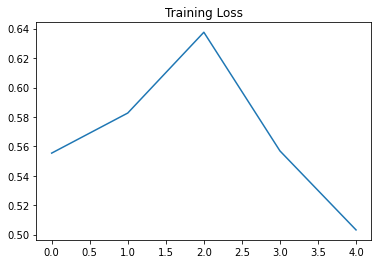

In [ ]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

In [ ]:
k=408

In [ ]:
k

409

In [ ]:
k=423

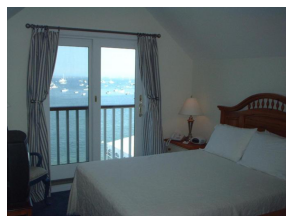

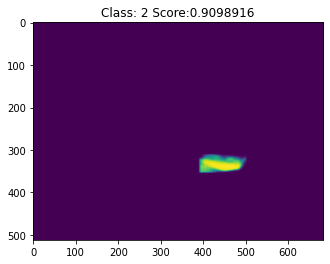

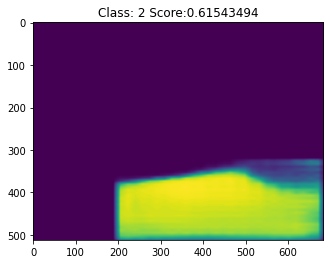

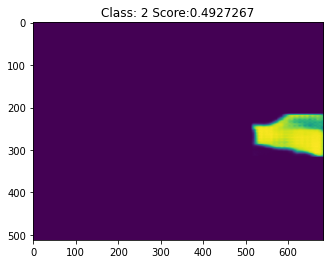

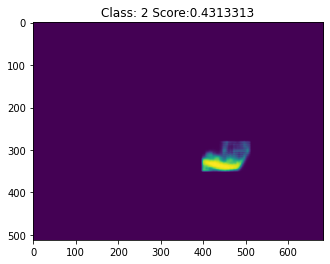

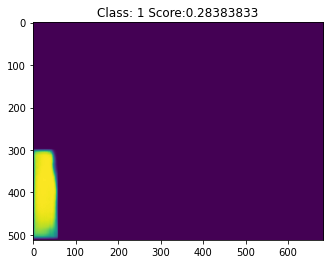

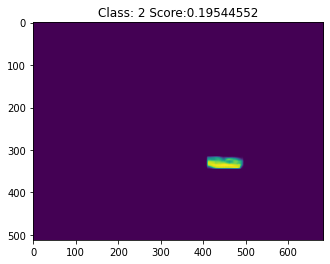

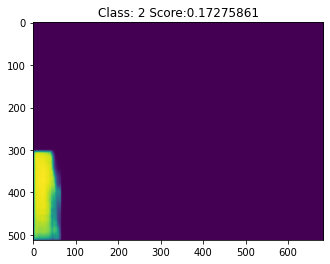

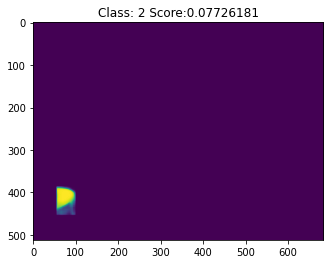

In [ ]:
model.eval()
k+=1
im = dataset_test[k][0]
show(im,sz=5)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()